# Atividade - Modelos de simulação de eventos discretos.
###  PPGEE/UFPA

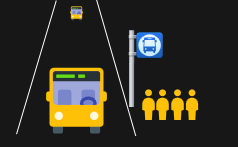

***
Este exemplo modela uma Estação de ônibus e passageiros que chegam para o transporte.
O objetivo deste modelo é analisar os dados de entrada, processamento e saída do sistema.

Para o cumprimento da atividade foram definidos dois eventos extras que ocorrem em intervalos exponenciais.
Os eventos são:
        1 - Ônibus poderá recarregar as baterias ao chegar na estação.
        2 - Passageiro pode não embarcar caso a capacidade do ônibus for excedida.
***

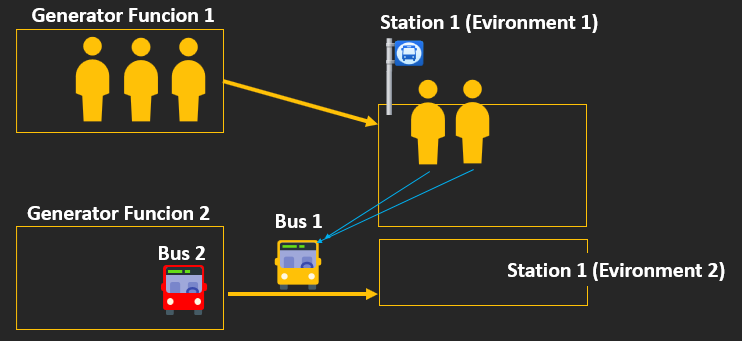

A simulação inicia com dois processos `Generator Function` que iniciam simultaneamente dentro do ambiente `Environment` simpy.
A primeira função gera passageiros que chegam na estação em intervalos exponenciais. Após a chegada, cada passageiro solicita o embarque para o ônibus que está em trânsito. 

***

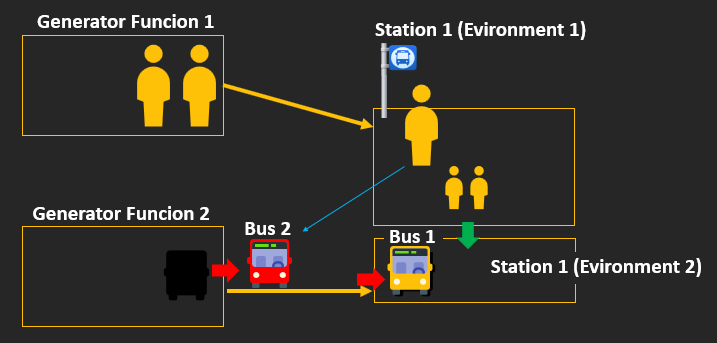

A segunda função gera o ônibus, também em intervalos exponenciais, executa uma rota desde a sua posição inicial (Garagem) até a chegada na estação. Ao chegar na estação, um evento de carregamento pode ser disparado. Em seguinda iniciar o processo de embarque de cada passageiro da fila. Caso o limite de capacidade do ônibus seja excedido, o embarque o passageiro é cancelado.

Durante o processo de embarque os próximos passageiros que chegarem à estação solicitam embarque para o próximo ônibus em trânsito.

In [21]:
import simpy
import random
import pandas as pd

class Estacao(object):
    
    def __init__(self, env, tmcp, tmco, tmep, capacidade):
        self.env = env
        self.tmcp = tmcp
        self.tmco = tmco
        self.tmep = tmep
        self.lstRequest = []
        self.capacidade = capacidade
        self.onibus = simpy.Resource(env, capacity=1)
        self.procOb = env.process(self.geraOnibus(self.env))
        self.procPg = env.process(self.geraPassageiros(self.env))
        

    def geraPassageiros(self, env):
        try:
            cont = 0
            while True:
                yield self.env.timeout(random.expovariate(1.0/self.tmcp))
                cont += 1
                tc = self.env.now
                print("    🧍‍♂️%.2f - Passageiro %d chegou na estação. " % (tc, cont))

                # Solicita ônibus
                self.env.process(self.solicitaEmbarque(env, cont, tc))
            
        except simpy.Interrupt:
            #print('🔴O processo foi interrompido🔴')
            pass
        
    def solicitaEmbarque(self, env, cont, tc):
        #Solicita o recurso onibus
        request = self.onibus.request()
        self.lstRequest.append({'id': cont, 'tc': tc, 'ts': None, 'tef': None, 'tea': None, 'req': request})
        #Aguarda em fila até a liberação do recurso
        yield request
        
            
    def geraOnibus(self, env):

        print ("🟡🚇🟡 %.2f - Ônibus à caminho da estação" % (env.now))
        yield env.timeout(random.expovariate(1.0/self.tmco))
        print ("\n🟢🚇🟢 %.2f - Ônibus chega na estação" % (env.now))
    
        
        if random.choice([False, True, False]):
            yield env.process(self.carregando(env))
        
        
        pg = len(self.lstRequest)
          
            
        print ("     🛂 %d passageiros na estação" % pg)
        
        stop = 0
        while stop < self.capacidade:
            pg = len(self.lstRequest)
            if stop < pg:
                
                tea = random.expovariate(1.0/self.tmep)
                yield env.timeout(tea)
                
                tc = self.lstRequest[stop]['tc']
                ts = env.now
                print ("    >>> %.2f - Passageiro %d - chegada: %.2f >< embarque: %.2f | tempo total: %.2f" % (ts, stop + 1, tc, ts ,(ts - tc)))
                self.lstRequest[stop]['ts'] = ts
                self.lstRequest[stop]['tef'] = (ts - tc) - tea
                self.lstRequest[stop]['tea'] = tea
                        
                yield self.onibus.release(self.lstRequest[stop])
            else:
                print ("    ⚠##### ✅%.2f - Embarque concluído, todos embacaram ✅ #####⚠" % (env.now))
                stop += 1
                break
    
            stop += 1
        
        if stop > self.capacidade:
            print ("    ⚠##### 🔴%.2f - Capacidade Execedida 🔴 #####⚠" % (env.now))
            stop += 1
    
        self.procPg.interrupt()            
        print("🚦🚇🚦 %.2f - Ônibus saindo da estação\n" % env.now)

        
        ds = pd.DataFrame(self.lstRequest)
        ds['No sistema'] = ds['ts'] - ds['tc']
        display(ds)
        
        for j in range(stop, len(self.lstRequest)): 
            print ("    ❌ passageiro %d não embarcou" % (j+1))
            yield self.onibus.release(self.lstRequest[j])
    
    def carregando(self, env):
        print("        🔌⚡ %.2f - Iniciando o carregameto de baterias do ônibus" % env.now )
        yield env.timeout(5.0)
        print("         🔋 %.2f - Carga Completa" % env.now)
        

In [24]:
env = simpy.Environment()
SEED = random.seed(4)
TMCP = 0.5 # Tempo médio de chegadas de passageiros
TMCO = 2 # Tempo médio de chegada do ônibus
TMEP = 0.5 # Tempo médio de embarque de passageiros (Atendimento)
CAPACIDADE = 15 #Capacidade de lotação do ônibus

est = Estacao(env, TMCP, TMCO, TMEP, CAPACIDADE)
env.run(30)

🟡🚇🟡 0.00 - Ônibus à caminho da estação
    🧍‍♂️0.05 - Passageiro 1 chegou na estação. 
    🧍‍♂️0.31 - Passageiro 2 chegou na estação. 
    🧍‍♂️0.39 - Passageiro 3 chegou na estação. 
    🧍‍♂️0.43 - Passageiro 4 chegou na estação. 

🟢🚇🟢 0.54 - Ônibus chega na estação
        🔌⚡ 0.54 - Iniciando o carregameto de baterias do ônibus
    🧍‍♂️0.68 - Passageiro 5 chegou na estação. 
    🧍‍♂️1.49 - Passageiro 6 chegou na estação. 
    🧍‍♂️2.21 - Passageiro 7 chegou na estação. 
    🧍‍♂️2.34 - Passageiro 8 chegou na estação. 
    🧍‍♂️2.72 - Passageiro 9 chegou na estação. 
    🧍‍♂️2.88 - Passageiro 10 chegou na estação. 
    🧍‍♂️2.98 - Passageiro 11 chegou na estação. 
    🧍‍♂️3.04 - Passageiro 12 chegou na estação. 
    🧍‍♂️3.16 - Passageiro 13 chegou na estação. 
    🧍‍♂️4.47 - Passageiro 14 chegou na estação. 
    🧍‍♂️5.35 - Passageiro 15 chegou na estação. 
         🔋 5.54 - Carga Completa
     🛂 15 passageiros na estação
    🧍‍♂️6.17 - Passageiro 16 chegou na estação. 
    🧍‍♂️6.28 - Passa

,id,tc,ts,tef,tea,req,No sistema
0,1,0.054442,6.344341,5.484059,0.805840,<Request() object at 0x1dbbf624130>,6.289898
1,2,0.306581,6.837396,6.037760,0.493056,<Request() object at 0x1dbc0aee850>,6.530815
2,3,0.390774,7.801696,6.446622,0.964300,<Request() object at 0x1dbc0b69af0>,7.410922
3,4,0.425189,7.847052,7.376507,0.045355,<Request() object at 0x1dbc0b69880>,7.421862
4,5,0.681930,8.312566,7.165122,0.465514,<Request() object at 0x1dbc0b69df0>,7.630636
5,6,1.487781,8.665129,6.824785,0.352563,<Request() object at 0x1dbc0b69190>,7.177348
6,7,2.212212,8.763009,6.452917,0.097880,<Request() object at 0x1dbc0bb8220>,6.550797
7,8,2.337680,8.809805,6.425329,0.046796,<Request() object at 0x1dbc0bb83d0>,6.472125
8,9,2.722349,10.173332,6.087456,1.363528,<Request() object at 0x1dbc0bb8580>,7.450984
9,10,2.884302,10.351846,7.289030,0.178513,<Request() object at 0x1dbc0bb8370>,7.467543


    ❌ passageiro 16 não embarcou
    ❌ passageiro 17 não embarcou
    ❌ passageiro 18 não embarcou
    ❌ passageiro 19 não embarcou
    ❌ passageiro 20 não embarcou
    ❌ passageiro 21 não embarcou
    ❌ passageiro 22 não embarcou
    ❌ passageiro 23 não embarcou
    ❌ passageiro 24 não embarcou
    ❌ passageiro 25 não embarcou
    ❌ passageiro 26 não embarcou
    ❌ passageiro 27 não embarcou
    ❌ passageiro 28 não embarcou
    ❌ passageiro 29 não embarcou
    ❌ passageiro 30 não embarcou
    ❌ passageiro 31 não embarcou
    ❌ passageiro 32 não embarcou
    ❌ passageiro 33 não embarcou
    ❌ passageiro 34 não embarcou
    ❌ passageiro 35 não embarcou
    ❌ passageiro 36 não embarcou
